# Import and Cleaning

In [1]:
# adding path to import custom functions
import sys
sys.path.append("/home/artur/code/masters-project/main_project/notebooks/model_creation")

In [2]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter, gmtime, strftime

from functions import remove_high_corr, scale_variables, best_params_grid, calculate_confusion_matrix, plot_roc_auc_curve, bart_auc_scorer, make_label, get_error_and_auc

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import RepeatedKFold, train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer

from ISLP.bart import BART

import session_info 

In [3]:
data = pd.read_csv("../data/pre_processed_tox_mordred_2d.csv")
data.head()

/tmp/ipykernel_881538/2169794993.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,26,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/pre_processed_tox_mordred_2d.csv")


,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,...,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex,SRW05,fda_approved
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,1.0
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,1.0
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,1.0
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [4]:
Y = data["fda_approved"]
Y = Y.astype(float)
Y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: fda_approved, dtype: float64

In [5]:
X = data.iloc[:, 32:-1]
X.head()

,ABC,nAcid,nBase,SpMax_A,SpMAD_A,VR1_A,VR3_A,nAromAtom,nSpiro,nBridgehead,...,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex,SRW05
0,2.449490,0.0,3.000000e+00,1.732051,0.866025,5.583629,0.803548,-8.881784e-16,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3.047207,0.0,-5.551115e-17,1.847759,1.045250,8.629874,1.462083,-8.881784e-16,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0
2,3.047207,0.0,-5.551115e-17,1.847759,1.045250,8.629874,1.462083,-8.881784e-16,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0
3,2.121320,0.0,1.000000e+00,1.618034,1.118034,5.891993,0.857304,-8.881784e-16,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0
4,2.449490,0.0,-5.551115e-17,1.732051,0.866025,5.583629,0.803548,-8.881784e-16,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [6]:
# separate train an test datasets

np.random.seed(750059)
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.25)

# Constant Variables

In [7]:
DESCRIPTOR_TYPE = "mordred"

# Scaling datsets

The datasets are being scaled to be used, when necessary, scaled

In [8]:
# TRAIN

x_train_scaled = scale_variables(x_train)

# adding constant
x_train_scaled = sm.add_constant(x_train_scaled)

x_train_scaled.head()

,const,ABC,nAcid,nBase,SpMax_A,SpMAD_A,VR1_A,VR3_A,nAromAtom,nSpiro,...,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex,SRW05
0,1.0,-0.667852,-0.384474,0.716036,-0.474019,0.848506,-0.019773,-0.658911,-1.195666,-0.149937,...,-0.974595,0.293934,-1.178886,-0.676478,0.400403,-1.339188,-1.139750,-0.954015,0.764870,-0.775185
1,1.0,-0.634676,1.263603,-0.576832,-0.493713,-0.570878,-0.019770,-0.260507,-1.195666,-0.149937,...,0.474196,-0.501413,0.197238,-0.717852,0.334408,1.254963,0.359357,-0.954015,-0.528596,1.005697
2,1.0,-0.634801,-0.384474,-0.576832,0.125398,-0.077385,-0.019773,-0.652923,0.203106,-0.149937,...,0.748898,-0.241046,1.403380,0.398172,1.992010,-1.339188,-1.139750,-0.954015,-0.851963,1.005697
3,1.0,-0.928795,-0.384474,-0.576832,-0.639398,-0.541615,-0.019773,-0.913862,-1.195666,-0.149937,...,0.451744,-0.138165,-0.423838,-0.659743,-1.544894,-1.339188,-1.139750,-0.954015,-0.851963,-0.775185
4,1.0,-0.098379,-0.384474,-0.576832,0.627465,0.530731,-0.019771,-0.150414,0.203106,-0.149937,...,0.601422,0.307028,0.224785,0.474765,1.181971,0.898936,0.158008,-0.954015,0.764870,1.485938


In [9]:
# TEST

x_test_scaled = scale_variables(x_test)

# adding constant
x_test_scaled = sm.add_constant(x_test_scaled)

x_test_scaled.head()

,const,ABC,nAcid,nBase,SpMax_A,SpMAD_A,VR1_A,VR3_A,nAromAtom,nSpiro,...,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex,SRW05
0,1.0,-0.785261,-0.366362,0.657138,-0.375016,-0.195817,-0.032609,-0.676061,-0.231306,-0.127697,...,-0.278176,0.739885,0.651351,0.706911,0.991566,-1.234152,-1.038962,-0.893262,0.809151,-0.767529
1,1.0,0.281147,-0.366362,0.657138,0.617401,0.542001,-0.032601,1.159782,1.171324,-0.127697,...,0.058512,0.608704,-0.059568,-0.132083,0.361890,0.423618,0.453857,0.757097,0.809151,1.005275
2,1.0,0.176725,-0.366362,-0.601380,-0.319789,1.333776,-0.032609,-0.079200,0.703781,-0.127697,...,-1.837277,-0.421619,-0.812582,-0.319766,0.604427,-1.105861,0.264432,0.152055,0.809151,2.481360
3,1.0,-0.501506,-0.366362,0.657138,-0.341673,-1.088014,-0.032609,-0.468684,-0.231306,-0.127697,...,0.440093,1.183588,0.276823,0.366924,2.714990,-0.236164,-1.038962,-0.893262,0.809151,-0.767529
4,1.0,0.173048,1.378920,0.657138,0.075743,-0.340614,-0.032608,0.051800,0.703781,-0.127697,...,0.279427,0.862868,-0.212233,1.575245,0.425183,0.613975,1.069551,1.140928,-0.176401,-0.767529


# Logistic Regression

## Model Constant Variables

In [10]:
model_name_title = "Logistic Regression"
model_name_path = "logistic_regression"

## Cross Validation

Here, I will use the best_params_grid function, which looks for the best hyperparameters, using CV. There are no hyperparameters in Logistic Regression, so this function will only perform CV.

In [11]:
model_params_lr = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {}
    }
}

In [12]:
gs_result_lr, gs_result_lr_full = best_params_grid(x_train, y_train, model_params_lr)

Starting Grid Search for Logistic Regression: 12:57


/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Finished Grid Search for Logistic Regression: 12:57
Tempo de execução:  0.2 minutos


/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
gs_result_lr

,model,best_score,best_params
0,Logistic Regression,0.710152,{}


## Calculating Logistic Regression in R

## Saving Datasets to use in R

The logistic regression calculation was presenting problems in Python, so it will be performed in R, in a separate notebook, saved in the folder `logistic_regression`. Here, I will save the training and test datasets, to use them in R.

In [14]:
# reseting indices
x_train_scaled = x_train_scaled.reset_index()
x_test_scaled = x_test_scaled.reset_index()

y_train = y_train.reset_index()
y_test = y_test.reset_index()

In [15]:
# joining x and y training and test datasets
train = pd.concat([x_train_scaled, y_train], axis=1).drop(["index"], axis=1)
test = pd.concat([x_test_scaled, y_test], axis=1).drop(["index"], axis=1)

In [16]:
# saving datasets
train.to_csv(f"logistic_regression/data/train_{DESCRIPTOR_TYPE}.csv")
test.to_csv(f"logistic_regression/data/test_{DESCRIPTOR_TYPE}.csv")

## Importing results from R

In [17]:
results_log_reg_df = pd.read_csv(f"logistic_regression/data/lr_coefficients_{DESCRIPTOR_TYPE}.csv")
results_log_reg_df.head()

,Unnamed: 0,Estimate,Std. Error,z value,Pr(>|z|)
0,(Intercept),-3.493977e+14,2.769001e+06,-1.261818e+08,0
1,X,-2.235483e+10,1.736230e+03,-1.287550e+07,0
2,ABC,6.419923e+16,7.115832e+08,9.022028e+07,0
3,nAcid,2.012878e+14,5.795687e+06,3.473062e+07,0
4,nBase,1.597313e+14,3.520983e+06,4.536555e+07,0


In [18]:
# y predict in test set
y_predict_lr_prob = pd.read_csv(f"logistic_regression/data/y_predict_proba_test_{DESCRIPTOR_TYPE}.csv")
y_predict_lr_prob = y_predict_lr_prob["x"]
y_predict_lr_prob.head()

0    2.220446e-16
1    1.000000e+00
2    1.000000e+00
3    2.220446e-16
4    2.220446e-16
Name: x, dtype: float64

In [19]:
# here I use the make_label function to transform the probabilities into labels, using 0.5 as a cutoff

make_label_v = np.vectorize(make_label)
y_predict_labels_lr = make_label_v(y_predict_lr_prob)

In [20]:
# y predict in training set
y_predict_lr_prob_train = pd.read_csv(f"logistic_regression/data/y_predict_proba_train_{DESCRIPTOR_TYPE}.csv")
y_predict_lr_prob_train = y_predict_lr_prob_train["x"]
y_predict_lr_prob_train.head()

0    2.220446e-16
1    2.220446e-16
2    1.000000e+00
3    2.220446e-16
4    2.220446e-16
Name: x, dtype: float64

## Get Training Error and AUC

In [21]:
mis_rate_lr_train, auc_lr_train = get_error_and_auc(
    model=y_predict_lr_prob_train, 
    x=x_train_scaled,
    y_true=y_train["fda_approved"],
    transform_prob_into_label=True,
    log_reg=True
)

Training Misclassification Rate: 0.2734
Training AUC: 0.7266


## Test Error

In [22]:
mis_rate_lr, disp = calculate_confusion_matrix(
    y_test=y_test["fda_approved"], 
    y_pred=y_predict_labels_lr,
)

Misclassification rate: 0.3871


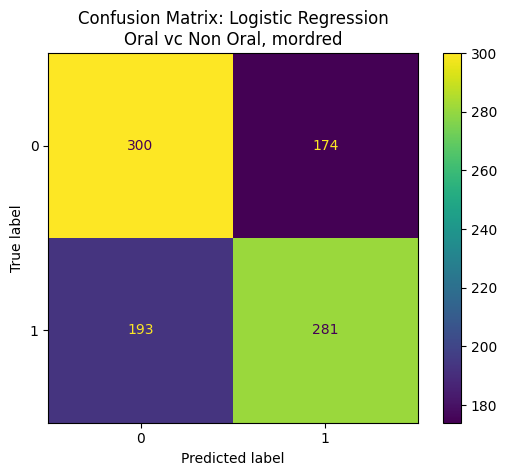

In [23]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

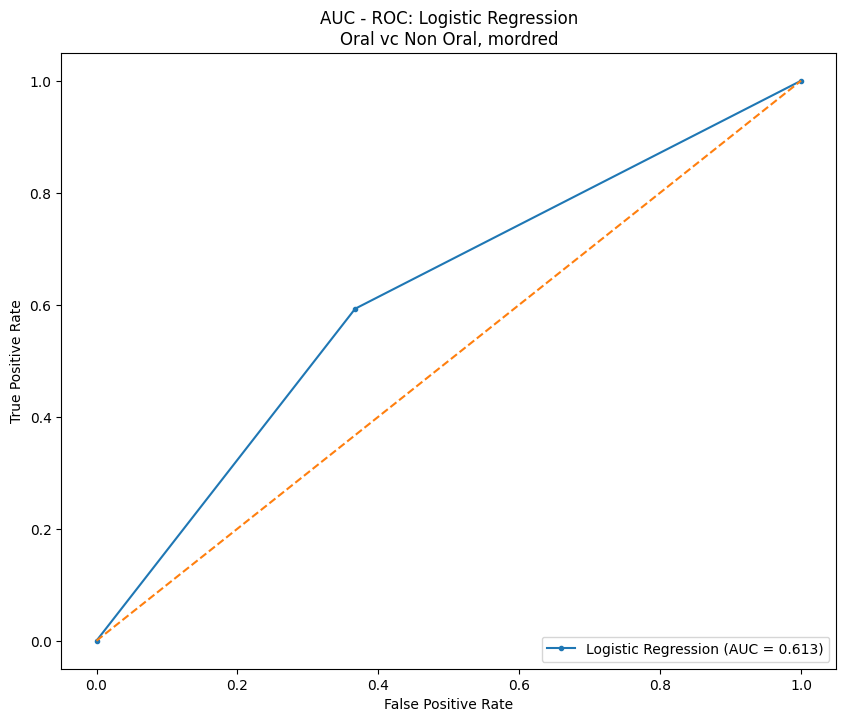

In [24]:
auc_lr = plot_roc_auc_curve(
    y_test=y_test["fda_approved"],
    y_pred=y_predict_lr_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

In [25]:
# converting results summary to pandas dataframe
results_log_reg_df = results_log_reg_df.rename(columns={"Unnamed: 0": "descriptor_name"})
results_log_reg_df = results_log_reg_df.set_index(results_log_reg_df["descriptor_name"]).drop("descriptor_name", axis=1)
results_log_reg_df.shape
results_log_reg_df.head()

,Estimate,Std. Error,z value,Pr(>|z|)
descriptor_name,,,,
(Intercept),-3.493977e+14,2.769001e+06,-1.261818e+08,0
X,-2.235483e+10,1.736230e+03,-1.287550e+07,0
ABC,6.419923e+16,7.115832e+08,9.022028e+07,0
nAcid,2.012878e+14,5.795687e+06,3.473062e+07,0
nBase,1.597313e+14,3.520983e+06,4.536555e+07,0


In [26]:
important_features_lr = results_log_reg_df[results_log_reg_df["Pr(>|z|)"] < 0.05]
important_features_lr = important_features_lr.reindex(important_features_lr['Estimate'].abs().sort_values(ascending=False).index)
print(important_features_lr.shape)
important_features_lr

(591, 4)


,Estimate,Std. Error,z value,Pr(>|z|)
descriptor_name,,,,
nAromAtom,-9.531405e+16,8.125764e+08,-1.172986e+08,0
ABC,6.419923e+16,7.115832e+08,9.022028e+07,0
NaaCH,3.422807e+16,3.758500e+08,9.106842e+07,0
nBondsD,2.597792e+16,2.831038e+08,9.176111e+07,0
NdssC,-2.475293e+16,1.925087e+08,-1.285808e+08,0
...,...,...,...,...
AATSC8c,-2.993958e+12,5.741933e+06,-5.214199e+05,0
AATSC4i,2.955167e+12,1.230626e+07,2.401353e+05,0
AATSC8se,-1.825883e+12,1.001304e+07,-1.823506e+05,0


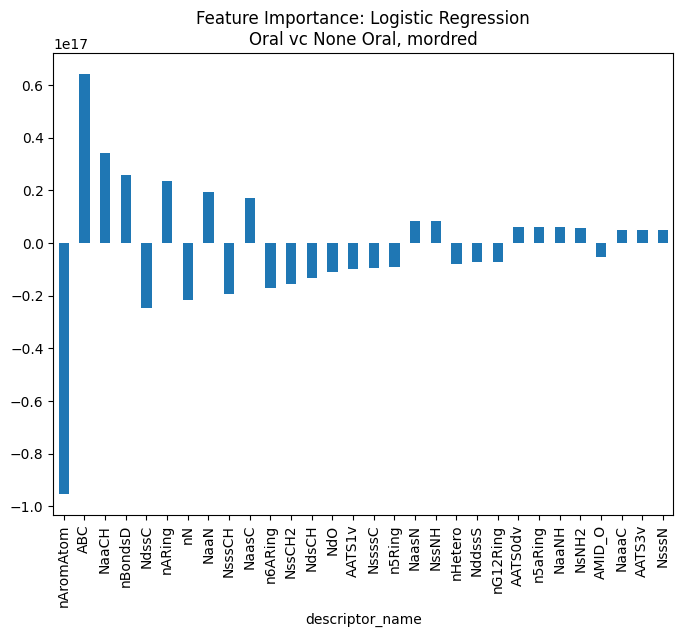

In [27]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

important_features_lr.iloc[:30,0].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

## Saving Results

In [29]:
# creating dataset to store final results from each model
final_results = pd.DataFrame(
    columns=[
        "model_name", 
        "cv_test_auc", 
        "training_mis_rate", 
        "test_mis_rate", 
        "training_auc",
        "test_auc"
    ]
)

In [30]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_lr["best_score"][0],
    mis_rate_lr_train,
    mis_rate_lr,
    auc_lr_train,
    auc_lr
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.710152,0.273399,0.387131,0.726601,0.612869


In [31]:
important_features_lr.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# TREES

# Decision Tree

## Model Constant Variables

In [27]:
model_name_title = "Decision Tree"
model_name_path = "decision_tree"

## Hyperparameter Fine Tuning

In [28]:
model_params = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': [1, 5, 10, 20, 50, 100, 150],
            'ccp_alpha': [0, 0.0001, 0.001, 0.1, 0.5, 1]
        }
    }
}

In [29]:
gs_result_dt, gs_result_dt_full = best_params_grid(x_train, y_train, model_params)

Starting Grid Search for Decision Tree: 12:30
Finished Grid Search for Decision Tree: 13:26
Tempo de execução:  55.4 minutos


In [30]:
gs_result_dt

,model,best_score,best_params
0,Decision Tree,0.727895,"{'ccp_alpha': 0, 'criterion': 'log_loss', 'max..."


## Fitting Tree

In [31]:
decision_tree_params = gs_result_dt.iloc[0,2]
decision_tree_params

{'ccp_alpha': 0, 'criterion': 'log_loss', 'max_depth': 5}

In [32]:
decision_tree = DecisionTreeClassifier(**decision_tree_params).fit(x_train, y_train)

## Get Training Error and AUC

In [33]:
mis_rate_dt_train, auc_dt_train = get_error_and_auc(
    model=decision_tree, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.2460
Training AUC: 0.7540


## Make Predictions

In [34]:
y_predict_dt_label = decision_tree.predict(x_test)
y_predict_dt_prob = decision_tree.predict_proba(x_test)[:, 1]

## Test Error

In [35]:
mis_rate_dt, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_dt_label,
)

Misclassification rate: 0.2838


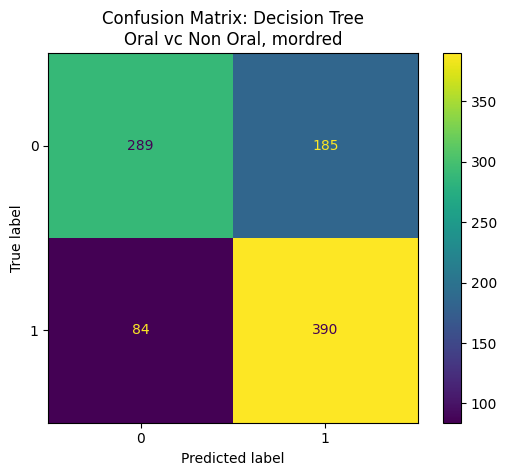

In [36]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

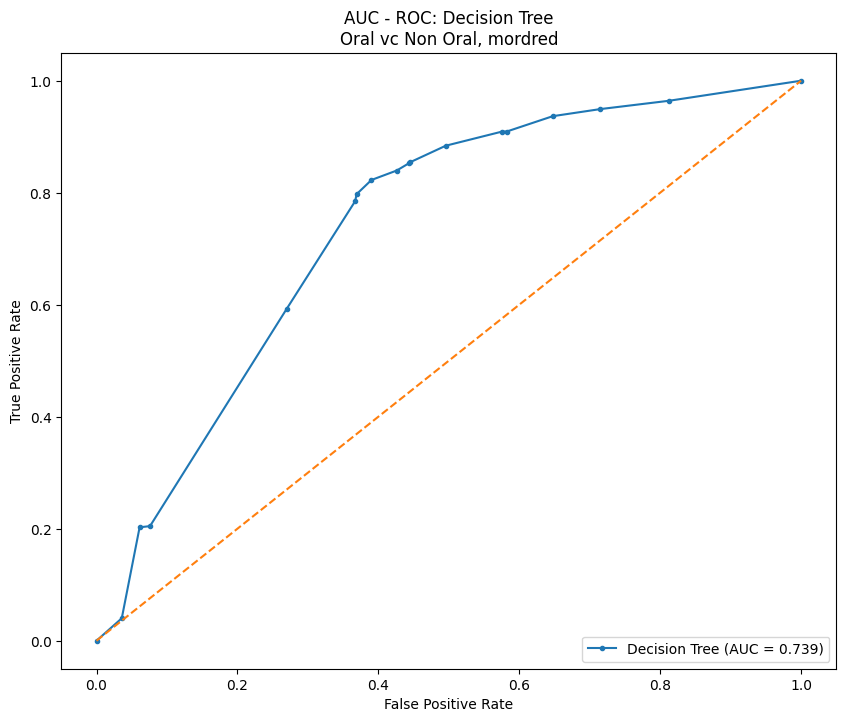

In [37]:
auc_dt = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_dt_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Visualizing the Tree

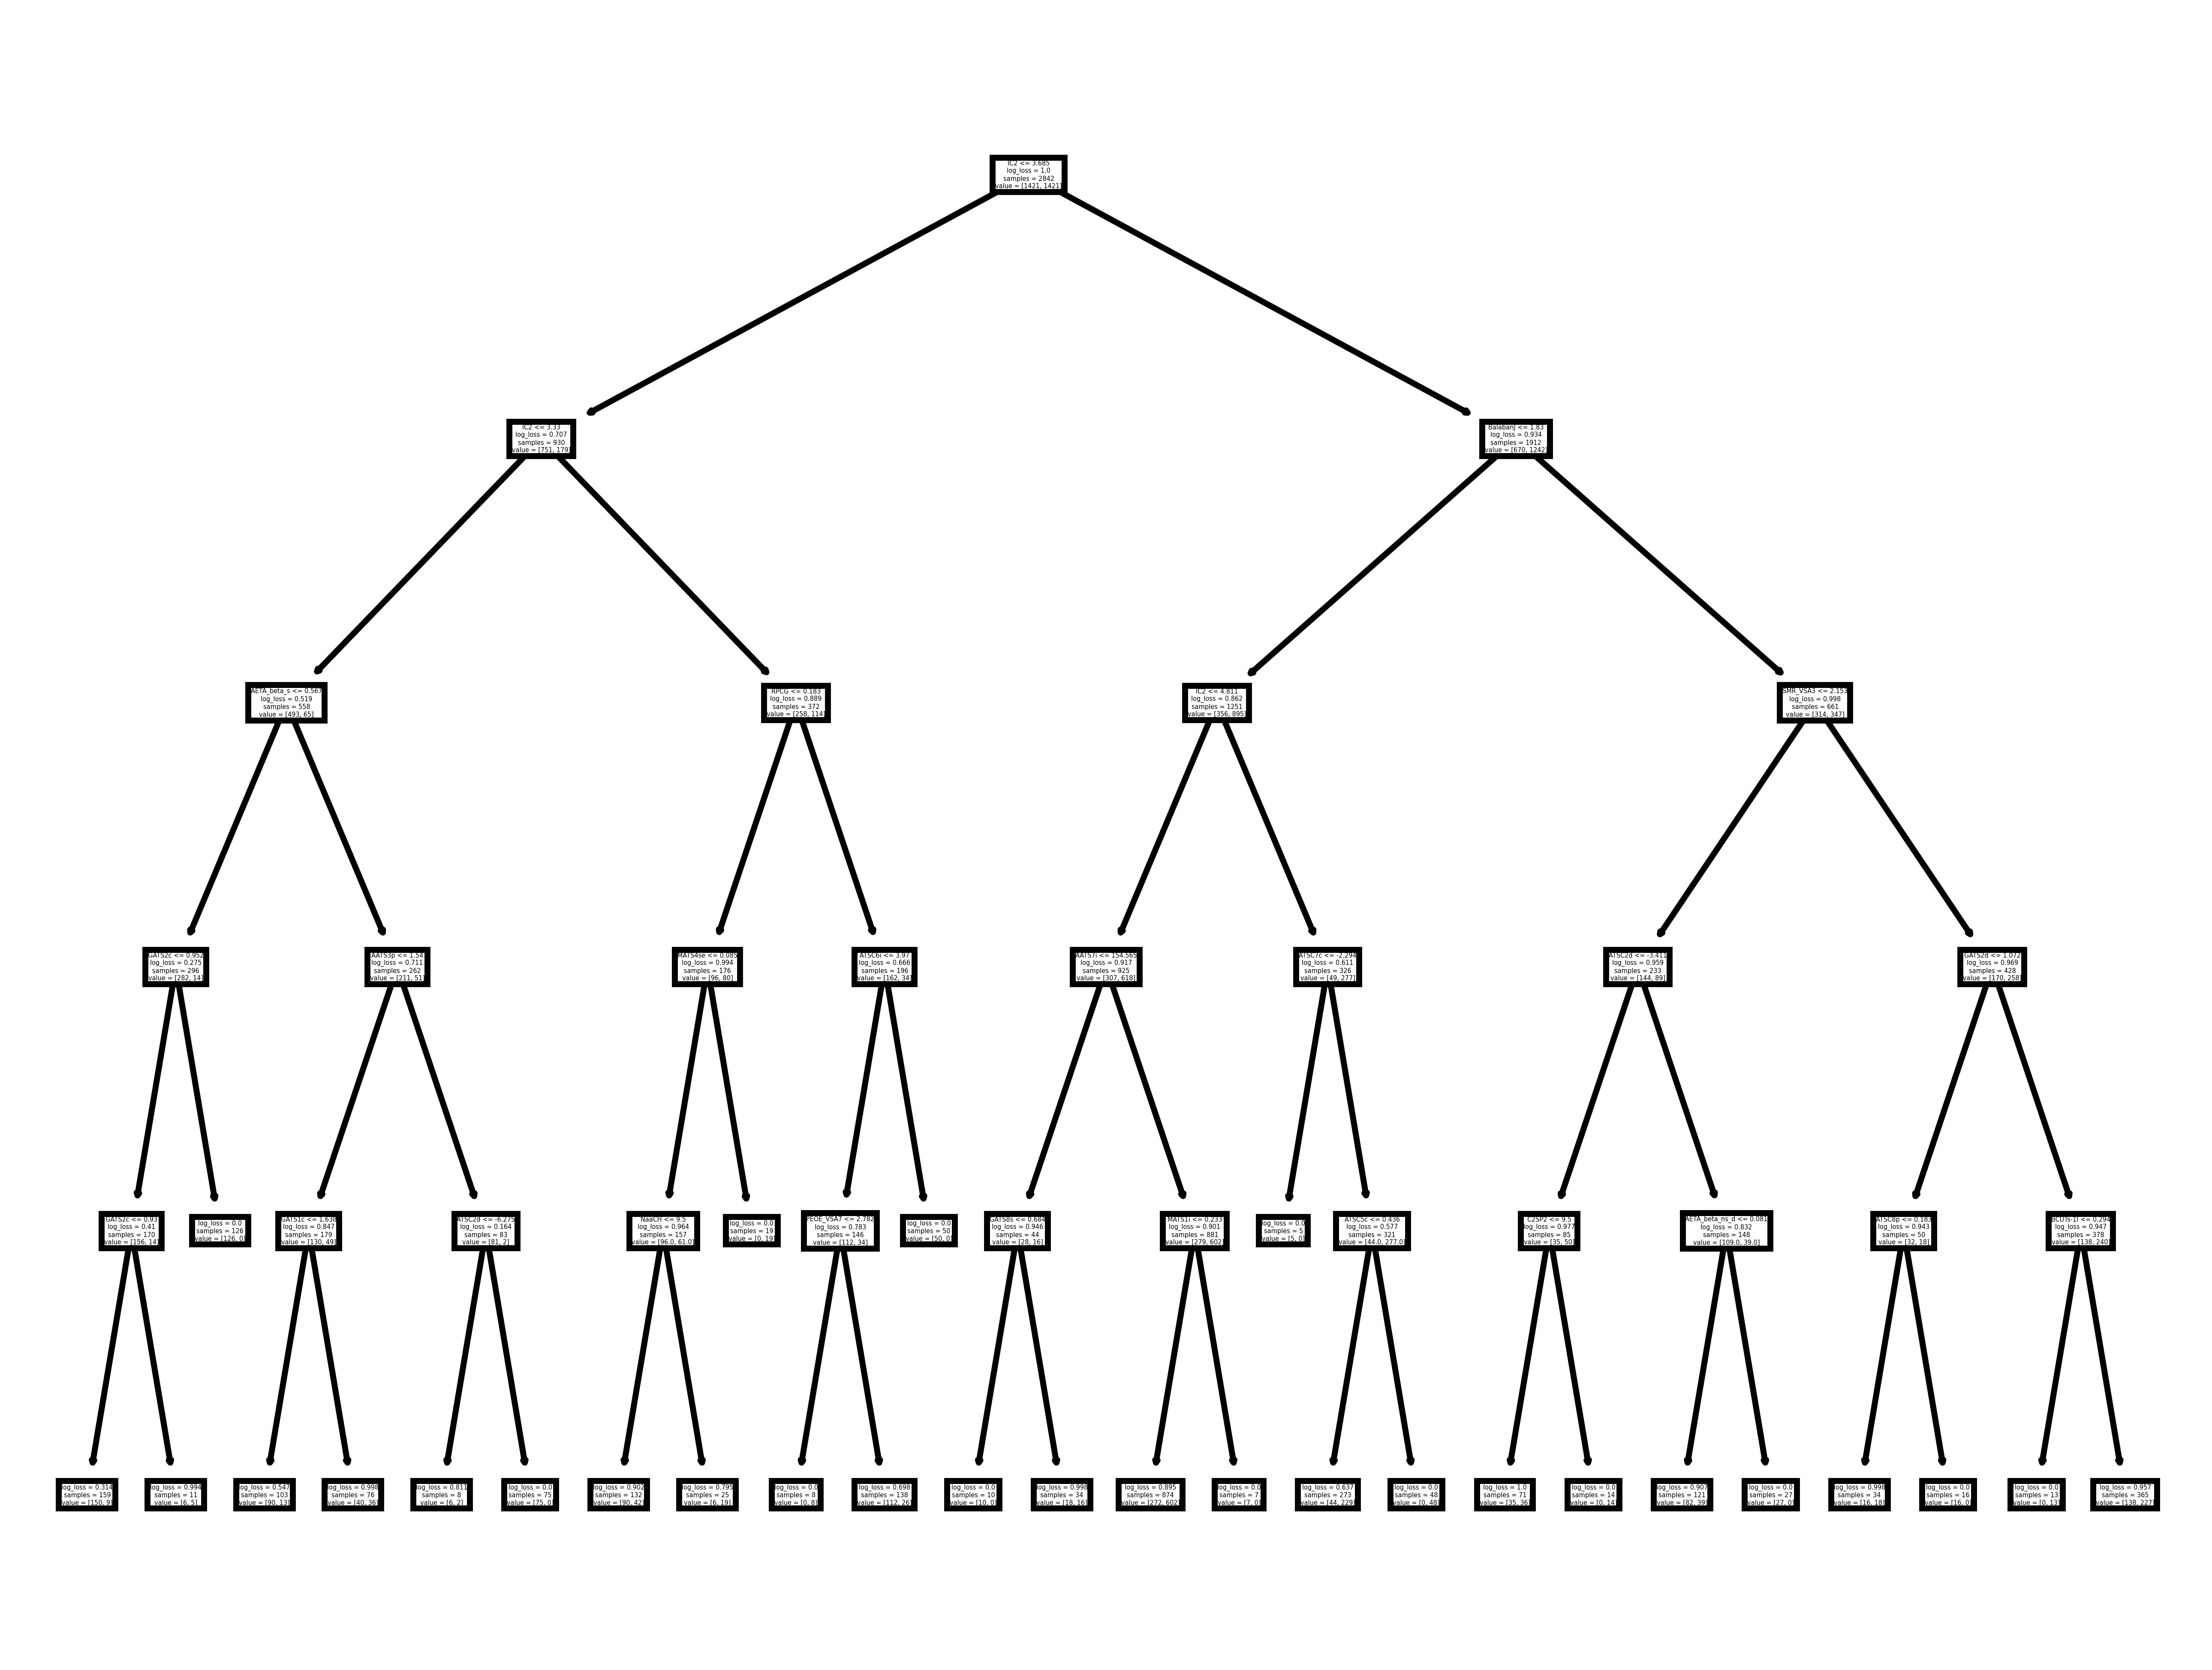

In [38]:
fig, ax = plt.subplots()
fig.dpi = 1000

tree.plot_tree(decision_tree, ax=ax, feature_names=list(x_train.columns))
plt.show()

fig.savefig(f"imgs/decision_tree_{DESCRIPTOR_TYPE}", dpi=1000)

## Feature Importance

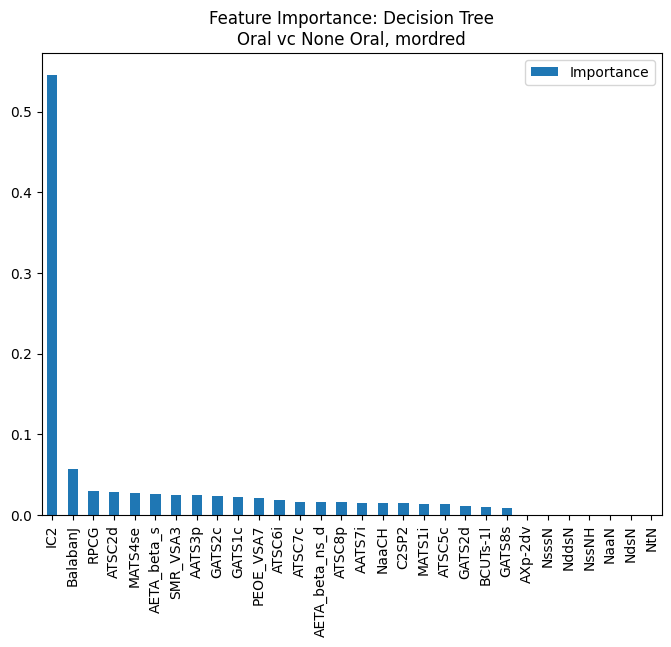

In [39]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(decision_tree.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [40]:
important_features_dt = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_dt

,Importance
GATS8s,0.009013
BCUTs-1l,0.010204
GATS2d,0.011507
ATSC5c,0.013041
MATS1i,0.013706
C2SP2,0.014164
NaaCH,0.014447
AATS7i,0.015138
ATSC8p,0.015486
AETA_beta_ns_d,0.015702


## Saving Results

In [41]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_dt["best_score"][0],
    mis_rate_dt_train,
    mis_rate_dt,
    auc_dt_train,
    auc_dt
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.710152,0.210767,0.306962,0.789233,0.733683
1,Decision Tree,0.727895,0.245954,0.283755,0.754046,0.738608


In [42]:
important_features_dt.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# Random Forest and Bagging

Bagging is just Random Forest, in which max_features is equal to the total number of features. Therefore, bagging will be done in the RF algorithm, and compared to RF.

## Model Constant Variables

In [43]:
model_name_title = "Random Forest"
model_name_path = "random_forest"

## Hyperparameter Fine Tuning

In [44]:
model_params = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 500, 1000], # number of trees
            'max_depth': [10, 50, 100],
            'max_features': ["sqrt", "log2"], # m, number of features considered in split. When it is equal to all predictor of dataset, it is bagging
            'ccp_alpha': [0.1, 0.5]
        }
    }
}

In [45]:
gs_result_rf, gs_result_rf_full = best_params_grid(x_train, y_train, model_params)

Starting Grid Search for Random Forest: 13:26
Finished Grid Search for Random Forest: 16:31
Tempo de execução:  185.2 minutos


In [46]:
gs_result_rf

,model,best_score,best_params
0,Random Forest,0.710645,"{'ccp_alpha': 0.1, 'max_depth': 50, 'max_featu..."


## Fitting Model

In [47]:
random_forest_params = gs_result_rf.iloc[0,2]
random_forest_params

{'ccp_alpha': 0.1,
 'max_depth': 50,
 'max_features': 'sqrt',
 'n_estimators': 1000}

In [48]:
random_forest = RandomForestClassifier(**random_forest_params).fit(x_train, y_train)

## Get Training Error and AUC

In [49]:
mis_rate_rf_train, auc_rf_train = get_error_and_auc(
    model=random_forest, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.5000
Training AUC: 0.5000


## Make Predictions

In [50]:
y_predict_rf_label = random_forest.predict(x_test)
y_predict_rf_prob = random_forest.predict_proba(x_test)[:, 1]

## Test Error

In [51]:
mis_rate_rf, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_rf_label,
)

Misclassification rate: 0.5000


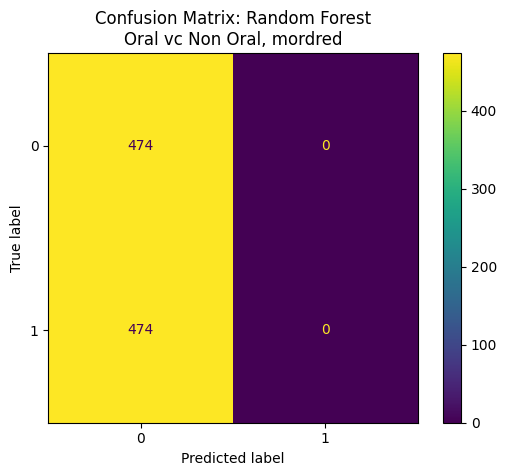

In [52]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

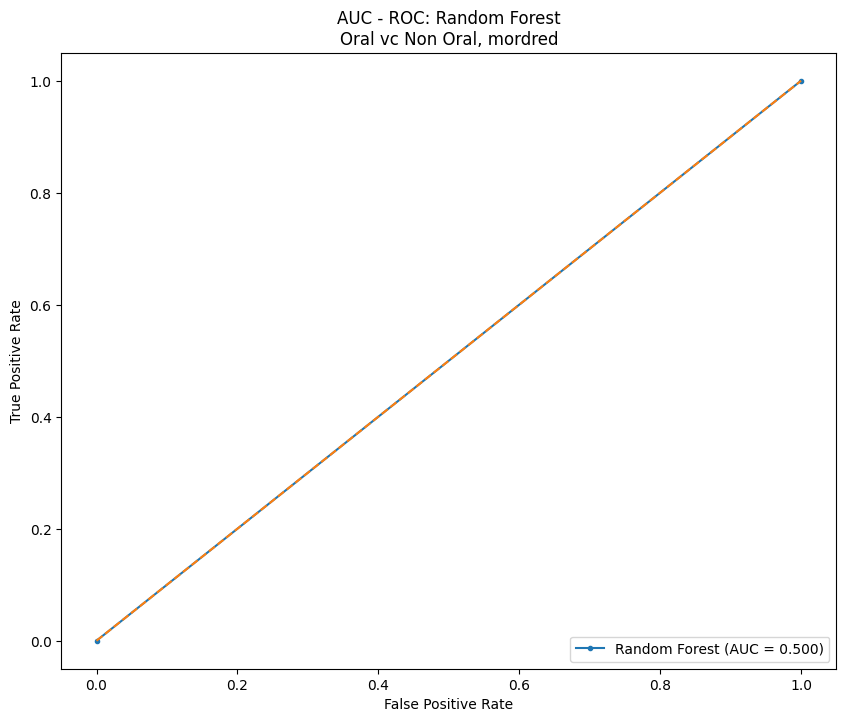

In [53]:
auc_rf = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_rf_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

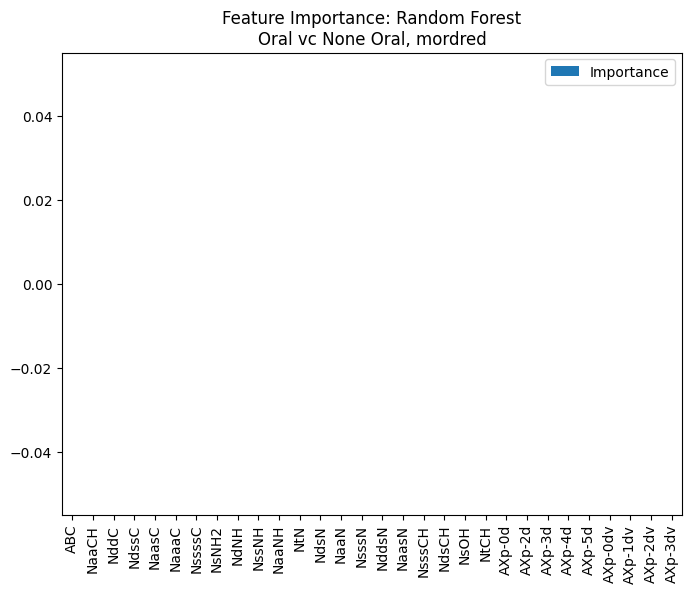

In [54]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(random_forest.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [55]:
important_features_rf = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_rf

,Importance


## Saving Results

In [56]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_rf["best_score"][0],
    mis_rate_rf_train,
    mis_rate_rf,
    auc_rf_train,
    auc_rf
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.710152,0.210767,0.306962,0.789233,0.733683
1,Decision Tree,0.727895,0.245954,0.283755,0.754046,0.738608
2,Random Forest,0.710645,0.500000,0.500000,0.500000,0.500000


In [57]:
important_features_rf.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# Boosting

## Model Constant Variables

In [58]:
model_name_title = "Gradiant Boosting"
model_name_path = "boosting"

## Hyperparameter Fine Tuning

In [59]:
model_params = {
    'Boosting': {
            'model': GradientBoostingClassifier(),
            'params': {
                'n_estimators' : [100, 500], # number of trees
                'learning_rate': [0.01, 0.1], # alfa
                'max_depth': [20],
        }
    }
}

In [60]:
gs_result_boo, gs_result_boo_full = best_params_grid(x_train_scaled, y_train, model_params)

Starting Grid Search for Boosting: 16:32
Finished Grid Search for Boosting: 04:24
Tempo de execução:  712.6 minutos


In [61]:
gs_result_boo

,model,best_score,best_params
0,Boosting,0.662506,"{'learning_rate': 0.1, 'max_depth': 20, 'n_est..."


## Fitting Model

In [62]:
boosting_params = gs_result_boo.iloc[0,2]
boosting_params

{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 500}

In [63]:
boosting = GradientBoostingClassifier(**boosting_params).fit(x_train, y_train)

## Get Training Error and AUC

In [64]:
mis_rate_boo_train, auc_boo_train = get_error_and_auc(
    model=boosting, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.0605
Training AUC: 0.9395


## Make Prediction

In [65]:
y_predict_boo_label = boosting.predict(x_test)
y_predict_boo_prob = boosting.predict_proba(x_test)[:, 1]

## Test Error

In [66]:
mis_rate_boo, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_boo_label,
)

Misclassification rate: 0.3333


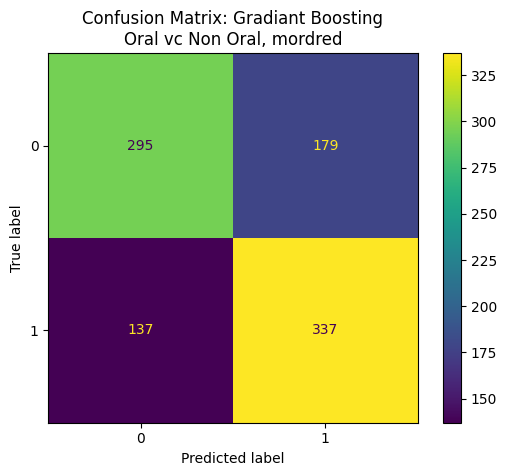

In [67]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

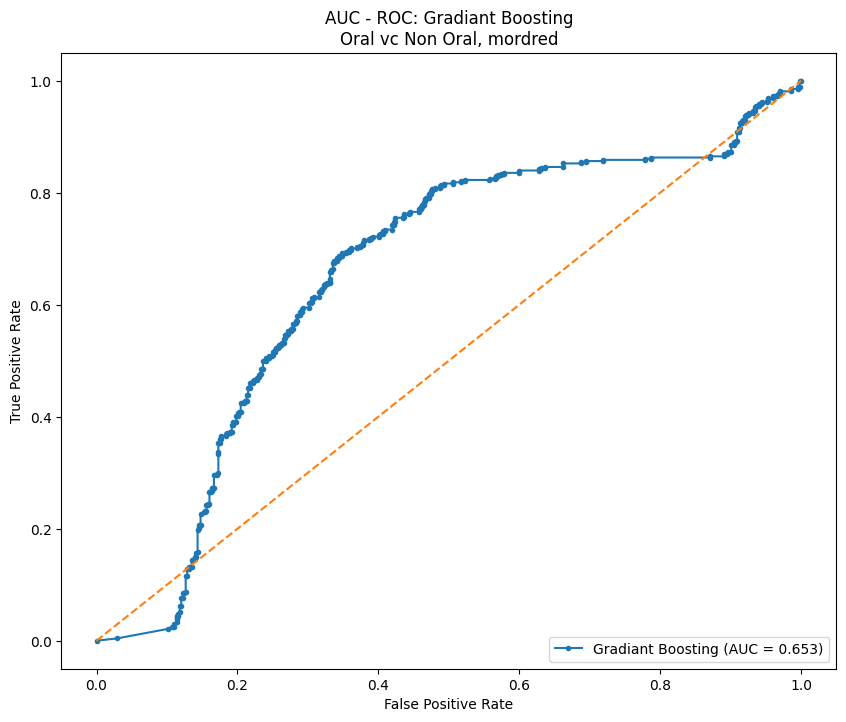

In [68]:
auc_boo = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_boo_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

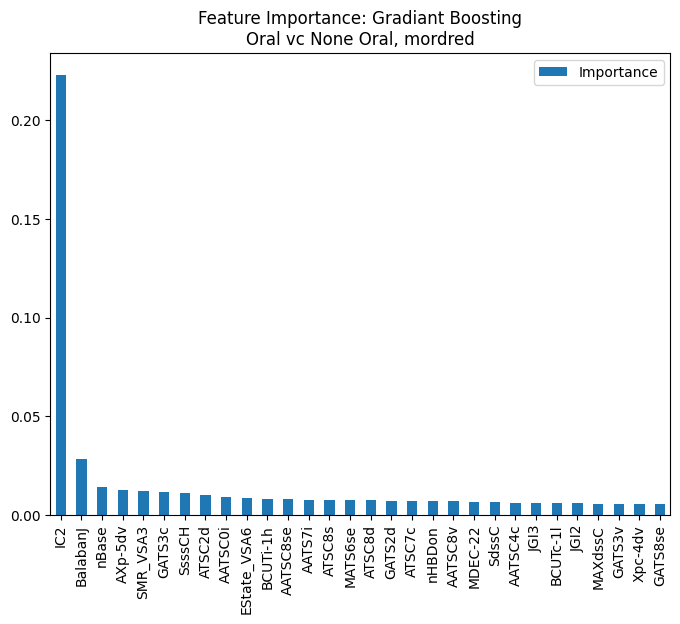

In [69]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(boosting.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [70]:
important_features_boo = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_boo

,Importance
n4aRing,2.984800e-26
ETA_dPsi_B,1.802681e-24
nG12FaRing,5.956656e-19
n12Ring,4.867023e-18
NsSH,1.331718e-17
...,...
SMR_VSA3,1.199834e-02
AXp-5dv,1.249645e-02
nBase,1.401523e-02
BalabanJ,2.852423e-02


## Saving Results

In [71]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_boo["best_score"][0],
    mis_rate_boo_train,
    mis_rate_boo,
    auc_boo_train,
    auc_boo
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.710152,0.210767,0.306962,0.789233,0.733683
1,Decision Tree,0.727895,0.245954,0.283755,0.754046,0.738608
2,Random Forest,0.710645,0.500000,0.500000,0.500000,0.500000
3,Gradiant Boosting,0.662506,0.060521,0.333333,0.939479,0.652615


In [72]:
important_features_boo.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# BART

## Model Constant Variables

In [73]:
model_name_title = "BART"
model_name_path = "bart"

## Hyperparameter Fine Tuning

In [74]:
# transforming x train and test as arrays for BART procedure

x_train_bart = np.asarray(x_train)
x_test_bart = np.asarray(x_test)

In [75]:
model_params = {
    'BART': {
        'model': BART(),
        'params': {
            'num_trees': [100, 500, 1000],
            'max_stages': [100, 500, 800, 1000], # B, number of iterations
            'burnin': [5, 10, 20] #L
        }
    }
}

For BART, the auc present in the best_params_grid need to recieve the y_predicted in labels, but this BART algorithm does it in probabilities. Because of this, I need to use a custom scorer, that first transforms the prediction to labels.

In [76]:
score = make_scorer(bart_auc_scorer, greater_is_better=True)

gs_result_bart, gs_result_bart_full = best_params_grid(x_train_bart, y_train, model_params, scoring=score)

Starting Grid Search for BART: 04:40
Finished Grid Search for BART: 10:53
Tempo de execução:  372.8 minutos


In [77]:
gs_result_bart

,model,best_score,best_params
0,BART,0.725543,"{'burnin': 20, 'max_stages': 100, 'num_trees':..."


# Fitting Model

In [78]:
bart_params = gs_result_bart.iloc[0,2]
bart_params

{'burnin': 20, 'max_stages': 100, 'num_trees': 500}

In [79]:
bart = BART(**bart_params)
bart.fit(x_train_bart, y_train)

BART(burnin=20, max_stages=100, num_trees=500)

## Get Training Error and AUC

In [80]:
mis_rate_bart_train, auc_bart_train = get_error_and_auc(
    model=bart, 
    x=x_train_bart,
    y_true=y_train,
    transform_prob_into_label=True
)

Training Misclassification Rate: 0.2449
Training AUC: 0.7551


## Make Prediction

In [81]:
# the bart algorithm predicts as probabilities
y_predict_bart_prob = bart.predict(x_test_bart)

In [82]:
# here I use the make_label function to transform the probabilities into labels, using 0.5 as a cutoff

y_predict_bart_label = make_label_v(y_predict_bart_prob)

## Test Error

In [83]:
mis_rate_bart, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_bart_label,
)

Misclassification rate: 0.2827


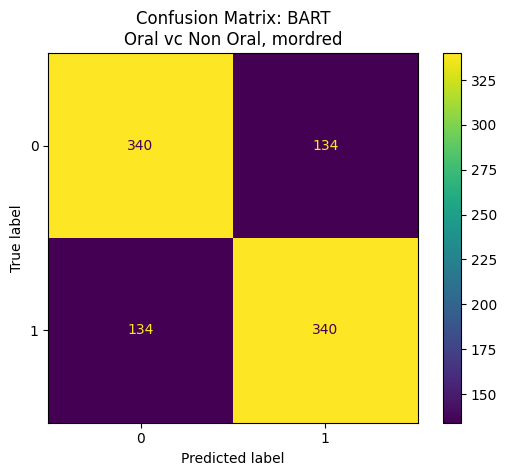

In [84]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

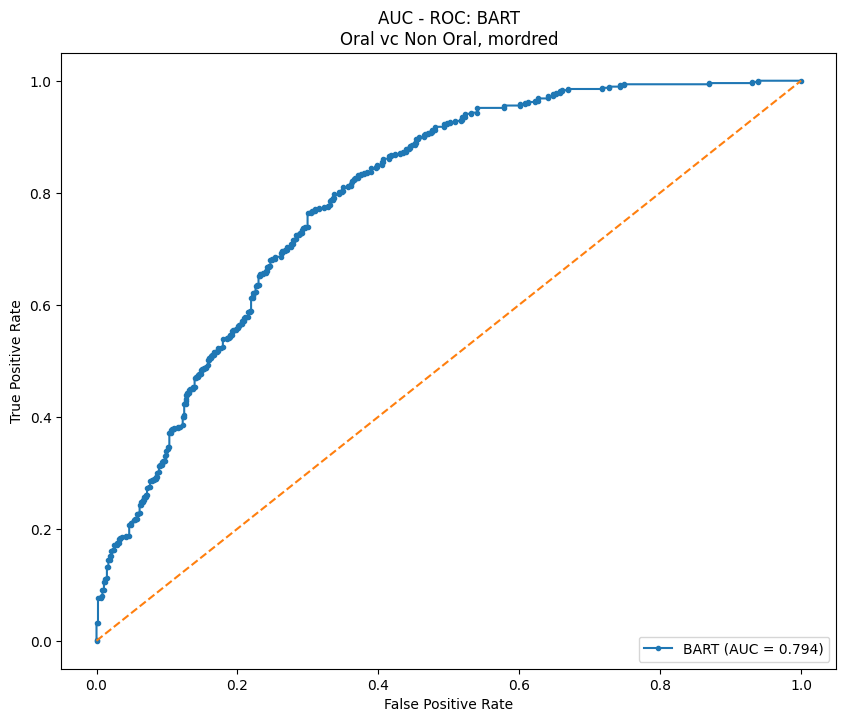

In [85]:
auc_bart = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_bart_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

We can check how many times each variable appeared in the collection
of trees. This gives a summary similar to the variable importance plot for
boosting and random forests.

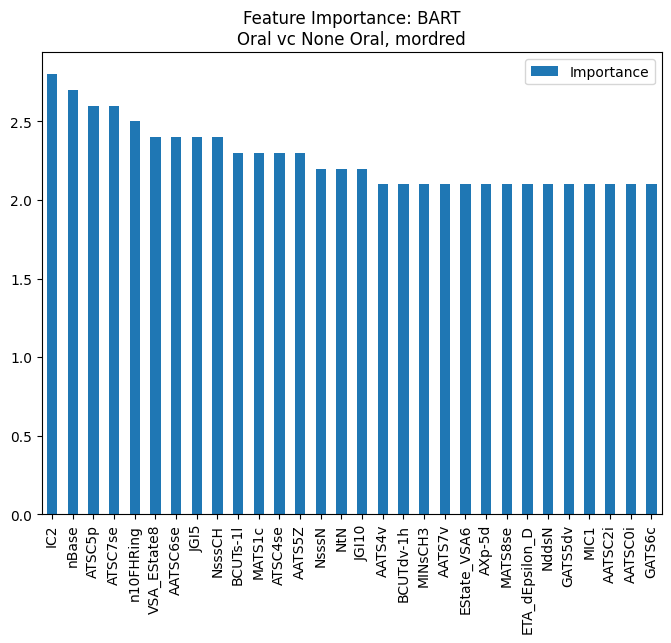

In [86]:
# Print the feature importances
fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(columns=["Importance"])
feat_importances["Importance"] = pd.Series(bart.variable_inclusion_.mean(0),index=X.columns).sort_values(ascending=False)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)


In [87]:
important_features_bart = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_bart

,Importance
SlogP_VSA11,0.3
ATSC7d,0.3
NssssSn,0.4
n9FRing,0.4
BCUTZ-1l,0.4
...,...
n10FHRing,2.5
ATSC7se,2.6
ATSC5p,2.6
nBase,2.7


## Saving Results

In [88]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_bart["best_score"][0],
    mis_rate_bart_train,
    mis_rate_bart,
    auc_bart_train,
    auc_bart
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.710152,0.210767,0.306962,0.789233,0.733683
1,Decision Tree,0.727895,0.245954,0.283755,0.754046,0.738608
2,Random Forest,0.710645,0.500000,0.500000,0.500000,0.500000
3,Gradiant Boosting,0.662506,0.060521,0.333333,0.939479,0.652615
4,BART,0.725543,0.244898,0.282700,0.755102,0.794046


In [89]:
important_features_bart.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# SVM

## Model Constant Variables

In [90]:
model_name_title = "SVM"
model_name_path = "svm"

## Hyperparameter Fine Tuning

In [91]:
scale = 1 / (x_train.shape[1] * x_train.var().mean())

model_params = {
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.1, 0.3, 0.5, 0.8, 1.0, 2, 5, 10],
            'kernel': ['rbf', 'sigmoid'],
            'gamma': ['auto', scale, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10]
        }
    }
}

In [92]:
gs_result_svm, gs_result_svm_full = best_params_grid(x_train, y_train, model_params)

Starting Grid Search for SVM: 10:54
Finished Grid Search for SVM: 13:59
Tempo de execução:  185.5 minutos


## Fitting Model

In [93]:
svm_params = gs_result_svm.iloc[0,2]
svm_params

{'C': 0.1, 'gamma': 9.250379923391385e-16, 'kernel': 'sigmoid'}

In [94]:
svm = SVC(**svm_params, probability=True).fit(x_train, y_train)

## Get Training Error and AUC

In [95]:
mis_rate_svm_train, auc_svm_train = get_error_and_auc(
    model=svm, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.4996
Training AUC: 0.5004


## Make Prediction

In [96]:
y_predict_svm_label = svm.predict(x_test)
y_predict_svm_prob = svm.predict_proba(x_test)[:, 1]

## Test Error

In [97]:
mis_rate_svm, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_svm_label,
)

Misclassification rate: 0.4989


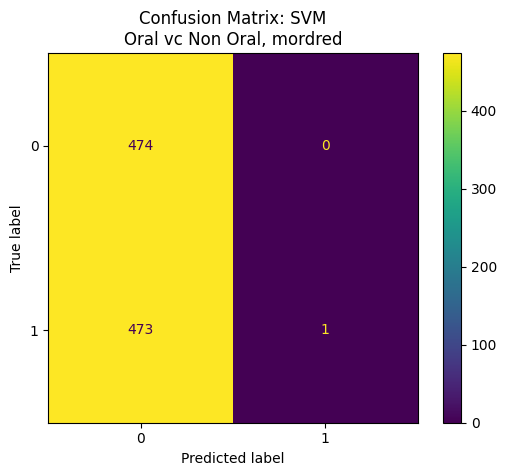

In [98]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

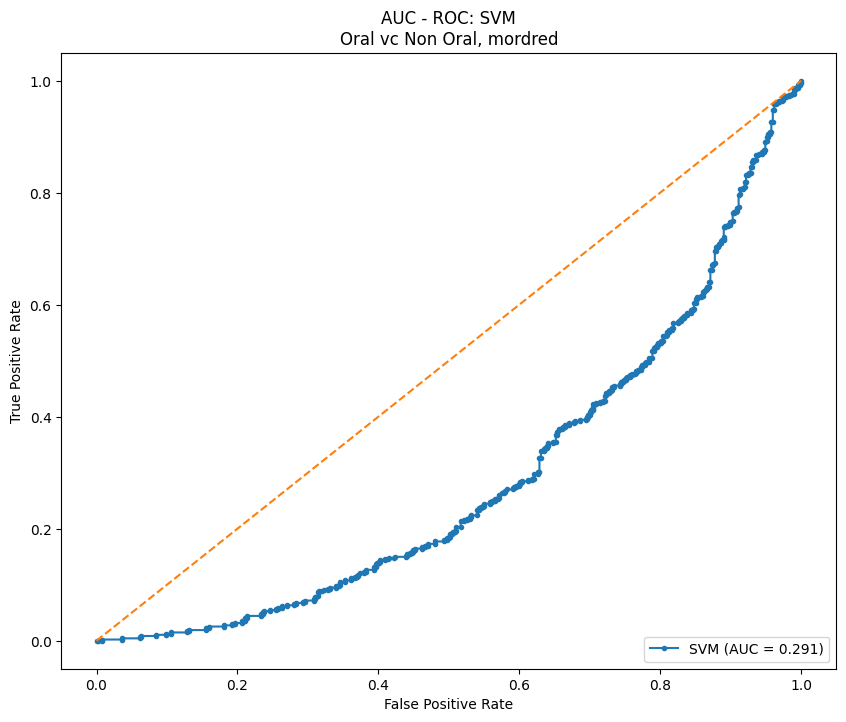

In [99]:
auc_svm = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_svm_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Saving Results

In [100]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_svm["best_score"][0],
    mis_rate_svm_train,
    mis_rate_svm,
    auc_svm_train,
    auc_svm
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.710152,0.210767,0.306962,0.789233,0.733683
1,Decision Tree,0.727895,0.245954,0.283755,0.754046,0.738608
2,Random Forest,0.710645,0.500000,0.500000,0.500000,0.500000
3,Gradiant Boosting,0.662506,0.060521,0.333333,0.939479,0.652615
4,BART,0.725543,0.244898,0.282700,0.755102,0.794046
5,SVM,0.700176,0.499648,0.498945,0.500352,0.291048


# Saving Final Datasets

In [101]:
# saving final_results dataset
final_results.to_csv(f"final_results/models_results_{DESCRIPTOR_TYPE}.csv", index=False)

In [102]:
session_info.show()